# Vancouver Coffee Community Ecology

### Determining the underlying factors that contribute to the assemblage of coffee shops in the corporate communities of Vancouver using the principles of plant community ecology

### Sean Kaczanowski

## Introduction

Coffee is a universally consumed beverage the world over. Coffee transcends both socio-economic classes as well as cultural boundaries. On street corners in neighbourhoods around the world, coffee shops are a staple of any corporate community. The city of Vancouver in Canada represents a perfect microcosm of this. The neighbourhoods and communities within are extremely diverse both socio-economically and culturally.

Coffee consumption is universal but how it is consumed is not. The preferences for how a coffee is prepared and the types of establishments that sell coffee are as diverse as those who consume it. From the price of a coffee to how a coffee is prepared to the types of establishments that sell coffee, the assemblage of coffee shops in any given community is a reflection of the people who inhabit them. Understanding the underlying factors that contribute to the coffee shop assemblage structure in any corporate community is key to the success of those who own and operate them. This is also key for those who want to open a coffee shop in any given community. Disentangling what it is that drives the structure of coffee shop assemblages is not an obvious task, however. 

What it is that drives the structure of assemblages in plant communities is a well established field in plant community ecology. Using abiotic factors (soil, temperature, elevation, slope aspect, etc) and biotic factors (species interactions, competition, etc.), ecologists have been describing plant communities using a number of diversity metrics for well over a century. Borrowing from a plant community ecologist perspective and implementing some of the diversity metrics this report aims to shed light on what drives the assemblage of coffee shops in any given corporate community using the city of Vancouver in Canada as an example. With a novel approach, the hope is that those in the business community who own or want to own a coffee shop will have a new framework of reference to work with to help make more informed decisions when it comes to owning and operating a coffee shop within a specific community.

## Data

### 0.0 Dependencies

In order to perform the analysis outlined above, several sources will be leveraged. Data obtained from the Foursquare API as well as from Statistics Canada and the City of Vancouver will be incorporated into the analyses performed by this report.

The data that will be used is as follows:

**Foursquare**
* Venue Name
* Category
* Latitude and Longitude

**City of Vancouver**
* Neighbourhood Names
* Neighbourhood Geographical Polygons

**Statistics Canada Census**
* Median Age
* Median Income
* Education
* Occupation

Using the data obtained from the three sources above the following steps will be undertaken to perform the final analyses. These include data preparation and final the data analyses.

**Data Preparation**
* Using the Foursquare and City of Vancouver data a dataframe that that allocates the appropriate neighbourhood to each venue will be constructed.
* For each coffee shop a type classification will be assigned (independant, local franchise and national/international franchise)
* Using the Statistics Canada Census data a dataframe containing the relevent data for each neighbourhood will be constructed.

**Data Analyses**
* Several diversity indices used in plant community ecology will be calculated using the neighbourhood venues dataframe.
* A multivariate linear/polynomial regression will be performed on the diversity indices using the Statistics Canada dataframe as the predictor variables to test the strength of the relationship between the diversity of coffee shops and the census data across neighbourhoods
* Machine learning classification models will also be applied to the data to classify the neighbourhoods across the city based on the diversity measures and census data within each neighbourhood.

Through this undertaking the idea of whether plant community ecology principles can be applied to the corporate communities of coffee shop assemblages can hopefully be definitively addressed. If it can then a powerful tool can be created that can be leveraged by both owners and prospective owners which can help guide business decisions moving forward.

Download, Install and Import All Dependencies

In [1]:
# pip install all dependencies
!pip install xlrd==1.2.0 pandas fiona shapely pyproj rtree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Import necesarry libraries
import numpy as np
import xlrd
import pandas as pd
import json
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
print('Libraries imported.')

Libraries imported.


In [3]:
# Import geopandas dependencies
import fiona
import shapely
import pyproj
import geopy
import rtree
print('Libraries imported.')

Libraries imported.


In [4]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# Import geopandas library
import geopandas
print('Libraries imported.')

Libraries imported.


In [6]:
# List of packages in environment
!pip list

Package                       Version
----------------------------- ----------------------------
absl-py                       1.2.0
aiohttp                       3.8.1
aiosignal                     1.2.0
alabaster                     0.7.12
albumentations                1.2.1
altair                        4.2.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
async-timeout                 4.0.2
asynctest                     0.13.0
atari-py                      0.2.9
atomicwrites                  1.4.1
attrs                         22.1.0
audioread                     2.1.9
autograd                      1.4
Babel                         2.10.3
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        5.0.1
blis                          0.7.

## 2.0 Data Preparation and Data Cleaning

### 2.1 City of Vancouver Neighborhoods and Geographic Coordinates

Using the City of Vancouver Open Data Portal a DataFrame containing a list of Vancouver neighborhoods and their associated latitudes and longitudes was constructed. This was accomplished by using csv data and the pandas library. The geo_point_2d column was split into two columns to create separate columns for latitudes and longitudes. The resulting DataFrame columns were renamed to reflect the relevent data for each. 

In [7]:
# Load data for Vancouver neighbourhood names, latitudes and longitudes
# Url for csv dataset from the City of Vancouver
url = "https://opendata.vancouver.ca/explore/dataset/local-area-boundary/download/?format=csv&timezone=America/Los_Angeles&lang=en&use_labels_for_header=true&csv_separator=%3B"

# Read in csv from url using semicolon separator
van_neighborhoods_df = pd.read_csv(url, sep=';')

# Split the geo_point_2d column into two columns for latitudes and longitudes
van_neighborhoods_df[['Latitudes', 'Longitudes']] = van_neighborhoods_df['geo_point_2d'].str.split(',', expand=True)

# Filter the columns to get the id, name and geographical coordinates
van_neighborhoods_df = van_neighborhoods_df[['MAPID', 'Name', 'Latitudes', 'Longitudes']]

# Inspect van_neighborhoods_df dataframe
van_neighborhoods_df.head()

,MAPID,Name,Latitudes,Longitudes
0,DS,Dunbar-Southlands,49.2379619063,-123.189546803
1,KERR,Kerrisdale,49.2236554855,-123.159576182
2,KIL,Killarney,49.2170216717,-123.037647029
3,KITS,Kitsilano,49.2675398494,-123.16329474
4,SC,South Cambie,49.2455564633,-123.121800916


### 2.2 Vancouver Neighborhood Boundaries

Using the City of Vancouver Open Data Portal a map containing the geographical polygons for each neighborhood was constructed. This was accomplished using geoJSON data and the geopandas library.

In [8]:
# Load data for Vancouver neighbourhood polygons

# Url for geoJSON dataset from the City of Vancouver
url = "https://opendata.vancouver.ca/explore/dataset/local-area-boundary/download/?format=geojson&timezone=America/Los_Angeles&lang=en"

# Read in a geoJSON file local-area-boundary.geojson to obtain neighbourhood polygons
van_polygons_gdf = geopandas.read_file(url)

# Inspect vanpolygons_gdf
van_polygons_gdf.head()

,name,mapid,geometry
0,Dunbar-Southlands,DS,"POLYGON ((-123.17017 49.24789, -123.17025 49.2..."
1,Kerrisdale,KERR,"POLYGON ((-123.17908 49.21556, -123.17564 49.2..."
2,Killarney,KIL,"POLYGON ((-123.02356 49.20015, -123.03998 49.2..."
3,Kitsilano,KITS,"POLYGON ((-123.13768 49.27532, -123.14375 49.2..."
4,South Cambie,SC,"POLYGON ((-123.11599 49.23794, -123.11617 49.2..."


In [43]:
# Create a single Vancouver polygon from neighborhood polygons using geopandas dissolve function
van_city_polygon_gdf = van_polygons_gdf.dissolve()
van_city_polygon_gdf = van_city_polygon_gdf.dissolve()
van_city_polygon_gdf = van_city_polygon_gdf[['geometry', 'name']]
van_city_polygon_gdf['name'] = 'Vancouver'
van_city_polygon_gdf

,geometry,name
0,"POLYGON ((-123.11284 49.20443, -123.11327 49.2...",Vancouver


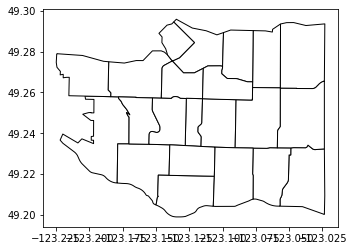

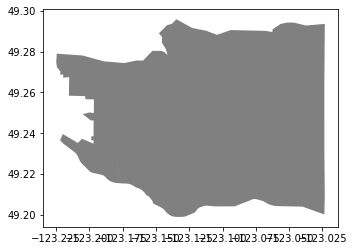

In [45]:
# Test maps of neighborhood polygons and city polygon
van_polygons_gdf.plot(color='white', edgecolor='black')
van_city_polygon_gdf.plot(color='grey')

### 2.2 Vancouver Grid Coordinates for Sampling

In [11]:
# Load data for Vancouver sample grid that will be used for running Foursquare API calls
# Url for csv dataset from the City of Vancouver
url = "https://opendata.vancouver.ca/explore/dataset/lidar-2018/download/?format=csv&timezone=America/Los_Angeles&lang=en&use_labels_for_header=true&csv_separator=%3B"

# Read in csv from url using semicolon separator
van_grid_df = pd.read_csv(url, sep=';')

# Filter columns and create two new columns 'Latitude' and 'Longitude' from the 'geo_point_2d' column
van_grid_df[['Latitude', 'Longitude']] = van_grid_df['geo_point_2d'].str.split(',', expand=True)
van_grid_df = van_grid_df[['NAME', 'Latitude', 'Longitude']]
van_grid_df.columns = ['Sample', 'Latitude', 'Longitude']

# create geopandas dataframe out of pandas dataframe
van_grid_df['geometry'] = geopandas.points_from_xy(van_grid_df['Longitude'], van_grid_df['Latitude'], crs='EPSG:4326')
van_grid_gdf = geopandas.GeoDataFrame(van_grid_df)

# Perform an sjoin between van_grid_gdf and van_polygons_gdf to get only the sample points that are within the neighborhoods
van_grid_gdf = geopandas.sjoin(van_grid_gdf, van_polygons_gdf)
van_grid_gdf = van_grid_gdf[['Sample', 'Latitude', 'Longitude', 'geometry']]

# Inspect van_grid_df dataframe
van_grid_gdf

,Sample,Latitude,Longitude,geometry
12,4840E_54530N,49.2340827497,-123.212914659,POINT (-123.21291 49.23408)
67,4860E_54530N,49.2341301169,-123.185441962,POINT (-123.18544 49.23413)
113,4850E_54520N,49.2251120475,-123.199142162,POINT (-123.19914 49.22511)
114,4850E_54530N,49.23410725,-123.19917832,POINT (-123.19918 49.23411)
116,4860E_54520N,49.2251349072,-123.185408298,POINT (-123.18541 49.22513)
...,...,...,...,...
87,4910E_54530N,49.2342199515,-123.116759948,POINT (-123.11676 49.23422)
88,4910E_54550N,49.2522103853,-123.116802371,POINT (-123.11680 49.25221)
147,4930E_54570N,49.2702252941,-123.089351975,POINT (-123.08935 49.27023)
148,4930E_54580N,49.2792204695,-123.089368224,POINT (-123.08937 49.27922)


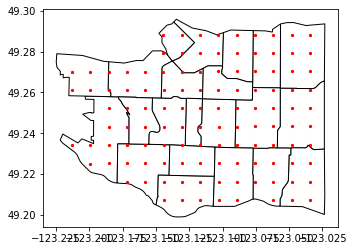

In [12]:
# Test map of sample points overlayed on top of the city of Vancouver polygon
van_polygon = van_polygons_gdf.plot(color='white', edgecolor='black')
van_grid_gdf.plot(ax=van_polygon, marker='o', color='red', markersize=5)

### 2.3 Statistics Canada 2016 Census Data for Vancouver Neighborhoods

In [13]:
# Load data for 2016 Statistics Canada Census
# Url for csv dataset from the City of Vancouver and Statistics Canada
url = "https://webtransfer.vancouver.ca/opendata/xls/CensusLocalAreaProfiles2016.xls"

# Read in xls file from url
van_census_df = pd.read_excel(url)

# Clean the dataframe
# Create a list of column names from the row values with the neighborhood names
van_census_columns = []
van_census_columns = van_census_df.values[3]

# Rename columns with neighborhood names
van_census_df.columns = van_census_columns

# Remove the top three rows of irrelevant data
van_census_df = van_census_df.iloc[4:]

# Reset Index
van_census_df.reset_index(drop=True, inplace=True)

# Inspect dataframe
van_census_df.head()

,ID,Variable,Arbutus-Ridge,Downtown,Dunbar-Southlands,Fairview,Grandview-Woodland,Hastings-Sunrise,Kensington-Cedar Cottage,Kerrisdale,...,Riley Park,Shaughnessy,South Cambie,Strathcona,Sunset,Victoria-Fraserview,West End,West Point Grey,Vancouver CSD,Vancouver CMA
0,1,Total - Age groups and average age of the popu...,15295,62030,21425,33620,29175,34575,49325,13975,...,22555,8430,7970,12585,36500,31065,47200,13065,631485,2463430
1,2,0 to 14 years,2015,4000,3545,2580,3210,4595,7060,1880,...,3415,1175,1105,1065,5460,3790,1945,1900,70530,362110
2,3,0 to 4 years,455,2080,675,1240,1320,1510,2515,430,...,1175,270,360,360,1695,1175,965,420,24615,116270
3,4,5 to 9 years,685,1105,1225,760,1025,1560,2390,600,...,1160,405,365,365,1780,1210,560,670,22905,122730
4,5,10 to 14 years,880,810,1650,580,865,1525,2160,845,...,1080,500,375,340,1985,1410,415,810,23010,123110


### 2.4 Foursquare Coffee Shop Data for Vancouver Neighborhoods

In [14]:
# Define Foursquare credentials
CLIENT_ID = 'Q3LEWT5YQVKABMEIIMQOODBS1FJ3DI4PZK02TFB445SNLIED'
CLIENT_SECRET = '5FG3OSBOY3Y2H4GEL1PGLLHYZS11XINPSH0TJPUESS42C0HX'
VERSION = '20180605'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: Q3LEWT5YQVKABMEIIMQOODBS1FJ3DI4PZK02TFB445SNLIED
CLIENT_SECRET:5FG3OSBOY3Y2H4GEL1PGLLHYZS11XINPSH0TJPUESS42C0HX


A function that can make Foursquare API calls for each neighborhood and append each call into a single dataframe was constructed. 

In [15]:
# Define function to GET all coffee shop venues in Vancouver using a radius of 500m for each sample point
def getVenues(sample, latitudes, longitudes, radius=500):
    
    QUERY = 'Coffee'
    LIMIT = '1000'
    
    venues_list=[]
    for sample, lat, lng in zip(sample, latitudes, longitudes):
        print(sample)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&query={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            QUERY,
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            sample,  
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Sample', 
                  'Venue ID',  
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

The function was then run to obtain all of the coffee venues within a 500m radius of each sample point.

In [16]:
# Run the above function on each neighborhood and create a new dataframe called van_coffee_shops_df
venues_df = getVenues(sample=van_grid_gdf['Sample'], 
                      latitudes=van_grid_gdf['Latitude'],
                      longitudes=van_grid_gdf['Longitude']
                     )

4840E_54530N
4860E_54530N
4850E_54520N
4850E_54530N
4860E_54520N
4860E_54540N
4860E_54550N
4870E_54540N
4850E_54560N
4850E_54570N
4840E_54560N
4840E_54570N
4860E_54560N
4890E_54580N
4860E_54570N
4880E_54560N
4880E_54570N
4870E_54560N
4870E_54570N
4880E_54510N
4880E_54520N
4880E_54530N
4870E_54510N
4870E_54520N
4870E_54530N
4890E_54520N
4890E_54530N
4890E_54500N
4900E_54500N
4900E_54510N
4890E_54510N
4910E_54500N
4910E_54510N
4890E_54560N
4890E_54570N
4900E_54570N
4900E_54560N
4910E_54560N
4910E_54570N
4890E_54590N
4900E_54580N
4900E_54590N
4900E_54520N
4910E_54520N
4900E_54530N
4900E_54540N
4890E_54540N
4890E_54550N
4900E_54550N
4920E_54510N
4930E_54510N
4930E_54520N
4920E_54500N
4920E_54520N
4930E_54500N
4920E_54540N
4920E_54550N
4910E_54540N
4920E_54530N
4920E_54560N
4930E_54560N
4920E_54570N
4920E_54590N
4910E_54580N
4910E_54590N
4920E_54580N
4930E_54540N
4930E_54530N
4940E_54530N
4950E_54530N
4930E_54550N
4940E_54540N
4940E_54550N
4940E_54560N
4950E_54540N
4950E_54550N
4950E_54560N

The resulting venues were then filtered to remove duplicates from API call overlaps and to only include venues with the Coffee Shop venue category.

In [26]:
# Select all of the venues that have a have a primary category of coffee shop or cafe
van_coffee_venues_df = venues_df.loc[venues_df['Venue Category'] == 'Coffee Shop']

# Drop all duplicate coffee shops by using Venue ID
van_coffee_venues_df = van_coffee_venues_df.drop_duplicates(subset=['Venue ID'])

# Drop Neighborhood Column
van_coffee_venues_df = van_coffee_venues_df.drop(['Sample'], axis=1)

# Reset Index and check the size of the resulting dataframe
van_coffee_venues_df.reset_index(drop=True, inplace=True)
van_coffee_venues_df.head()

,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,4ba807ccf964a520aac739e3,Blaq Sheep Coffee House And Bistro,49.235501,-123.185324,Coffee Shop
1,4b09c9d0f964a5209c1d23e3,Starbucks,49.246480,-123.185420,Coffee Shop
2,4b3275d7f964a5204f0c25e3,Tim Hortons,49.256089,-123.185587,Coffee Shop
3,4afb0728f964a520721a22e3,Bean Around The World,49.263776,-123.208040,Coffee Shop
4,53ee4c85498e08d769b448b3,Darcy's cafe,49.263758,-123.208483,Coffee Shop


In [55]:
# Inspect resulting dataframe
print('Shape of dataframe: ' + str(van_coffee_venues_df.shape))
print('Number of unique coffee shop venues: ' + str(len(van_coffee_venues_df['Venue'].unique())))
van_coffee_venues_df.groupby('Venue').count()

Shape of dataframe: (263, 5)
Number of unique coffee shop venues: 115


,Venue ID,Venue Latitude,Venue Longitude,Venue Category
Venue,,,,
49th Parallel & Lucky's Doughnuts,2,2,2,2
Aer café,1,1,1,1
Agro Cafe & Roastery,1,1,1,1
Aperture Coffee Bar,1,1,1,1
BG Urban Cafe,1,1,1,1
...,...,...,...,...
Woodvillage Cafe,1,1,1,1
Yaas Café & Gelateria,1,1,1,1
Zookaz Kaffe,1,1,1,1


In [19]:
# Create GeoPandas DataFrame from Panadas DataFrame
venue_geometry = geopandas.points_from_xy(van_coffee_venues_df['Venue Longitude'], van_coffee_venues_df['Venue Latitude'], crs='EPSG:4326')
venue_geometry_gdf = geopandas.GeoDataFrame(van_coffee_venues_df, geometry=venue_geometry)

# Perform an sjoin between 
venue_geometry_gdf = geopandas.sjoin(venue_geometry_gdf, van_polygons_gdf)

In [47]:
# Clean GeoDataFrame
# Filter columns and rename columns, reset index and inspect GeoDataFrame
van_coffee_geometry_gdf = venue_geometry_gdf[['Venue', 'geometry', 'mapid', 'name']]
van_coffee_geometry_gdf.columns = ['Venue', 'geometry', 'mapid', 'Neighborhood']
van_coffee_geometry_gdf.reset_index(drop=True, inplace=True)
van_coffee_geometry_gdf.head()

,Venue,geometry,mapid,Neighborhood
0,Blaq Sheep Coffee House And Bistro,POINT (-123.18532 49.23550),DS,Dunbar-Southlands
1,Starbucks,POINT (-123.18542 49.24648),DS,Dunbar-Southlands
2,Tim Hortons,POINT (-123.18559 49.25609),DS,Dunbar-Southlands
3,Bean Around The World,POINT (-123.20804 49.26378),WPG,West Point Grey
4,Darcy's cafe,POINT (-123.20848 49.26376),WPG,West Point Grey


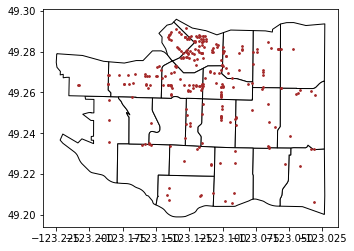

In [21]:
# Test map of neighborhood polygons and coffe shop locations
base = van_polygons_gdf.plot(color='white', edgecolor='black')
van_coffee_geometry_gdf.plot(ax=base, marker='o', color='brown', markersize=3)